# Comparison of Operational Data and Loads 
### (DTU @ IA  &  BB neo @ IIIB)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lacbox.io import load_stats
from helper_functions import extract_and_order_statistics, extract_and_combine_DEL


# Constants
SEEDS = 6
BB_PATH = Path.cwd().parent / 'my_design/BB_neo_turb_stats.csv'  # path to mean steady stats
DTU_PATH = Path.cwd().parent / 'dtu_10MW/turb/dtu_10mw_turb_stats.hdf5'  # path to mean steady stats
BB_SUBFOLDER = 'tcb'
DTU_SUBFOLDER = 'tca'

# Dict to identify which HAWC2 descriptions correspond to which channels
CHAN_DESCS = {'BldPit': 'pitch1 angle',
              'RotSpd': 'rotor speed',
              'Thrust': 'aero rotor thrust',
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# What channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

# Channel Labels for PLots
chan_labels = [
    'Pitch angle [deg]',
    'Rotor speed [rad/s]',
    'Thrust [kN]',
    'Generator torque [Nm]',
    'Electrical power [W]',
    'Tower-base FA [kNm]',
    'Tower-base SS [kNm]',
    'Yaw-bearing tilt [kNm]',
    'Yaw-bearing roll [kNm]',
    'Shaft torsion [kNm]',
    'OoP BRM [kNm]',
    'IP BRM [kNm]'    
]

# Fancy Plots

In [ ]:
import matplotlib
import scienceplots

matplotlib.rcParams.update(matplotlib.rcParamsDefault) # TO RESET  PLOTS
plt.style.use(['science'])

# Set global font properties
plt.rcParams['legend.frameon'] = True  # Enable the legend frame
plt.rcParams['legend.fancybox'] = False  # No fancybox, just a regular box
plt.rcParams['legend.edgecolor'] = 'black'  # Black edge color
plt.rcParams['legend.framealpha'] = 1  # No transparency
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'normal'

# PLot Operational and Design Loads
### (Maybe add a MAX dashed line)

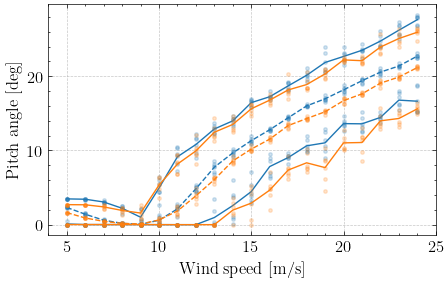

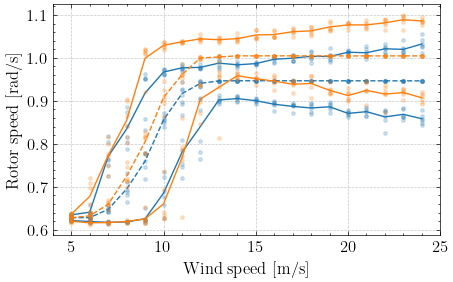

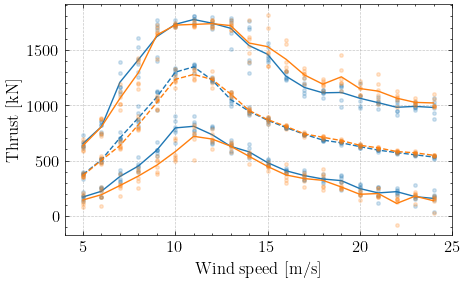

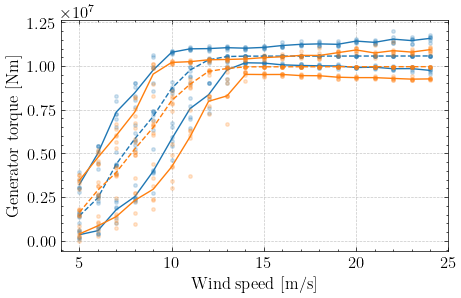

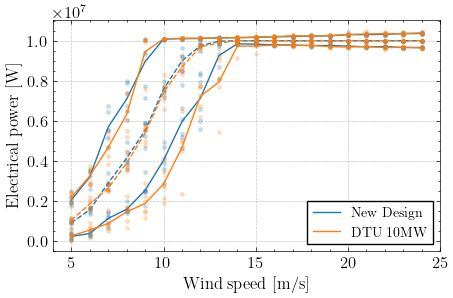

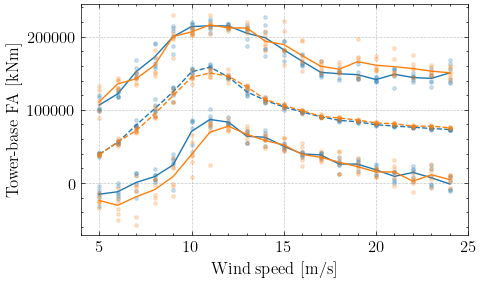

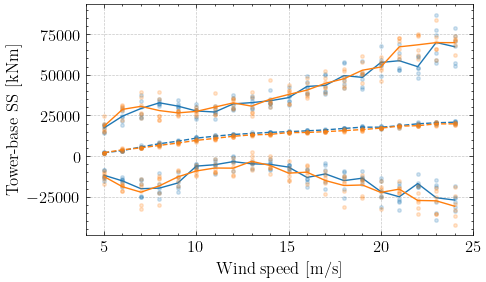

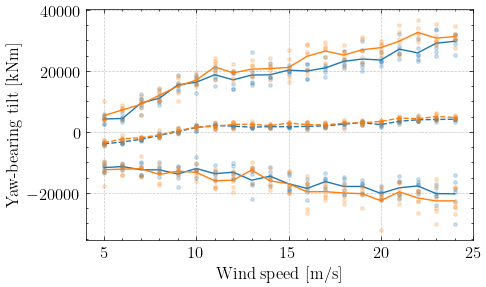

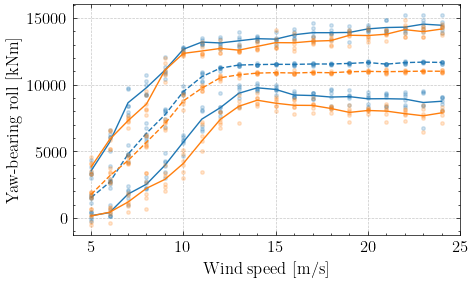

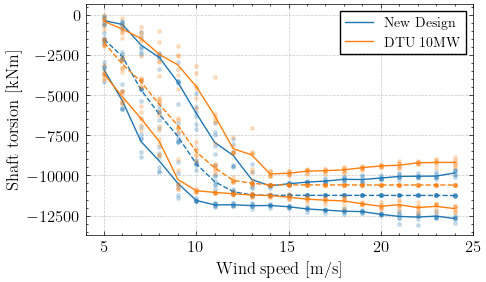

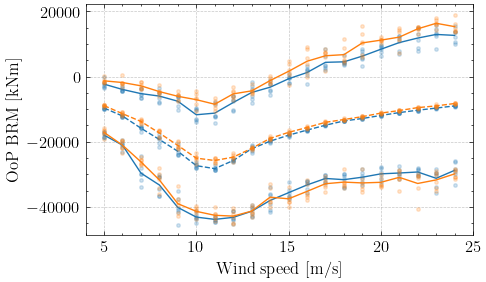

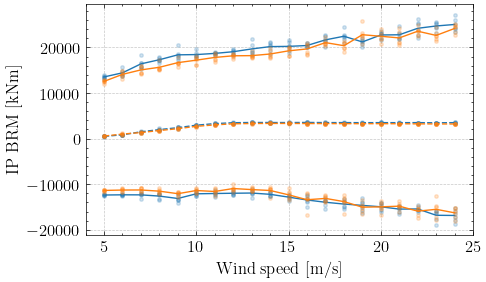

In [9]:
# Initialize dict
extreme_values_dict_BB = {key: None for key in chan_ids}
extreme_values_dict_DTU = {key: None for key in chan_ids}

# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=BB_SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=DTU_SUBFOLDER, statstype='turb')

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_order_statistics(wsps_BB, chan_df_BB, SEEDS)    
    points_DTU, lines_DTU = extract_and_order_statistics(wsps_DTU, chan_df_DTU, SEEDS)

    # Get overall max and min values for Extreme Load Calculation
    overall_min_BB = min(lines_BB['max'].min(), lines_BB['min'].min())
    overall_max_BB = max(lines_BB['max'].max(), lines_BB['min'].max())
    overall_min_DTU = min(lines_DTU['max'].min(), lines_DTU['min'].min())
    overall_max_DTU = max(lines_DTU['max'].max(), lines_DTU['min'].max())
    largest_abs_value_BB = overall_min_BB if abs(overall_min_BB) > abs(overall_max_BB) else overall_max_BB
    largest_abs_value_DTU = overall_min_DTU if abs(overall_min_DTU) > abs(overall_max_DTU) else overall_max_DTU
    extreme_values_dict_BB[chan_id] = largest_abs_value_BB
    extreme_values_dict_DTU[chan_id] = largest_abs_value_DTU

    # Initialize
    plt.figure(figsize=(5, 3))

    # Plot BB
    plt.plot(points_BB['wsp'], points_BB['max'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['mean'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(points_BB['wsp'], points_BB['min'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(lines_BB['wsp'], lines_BB['max'], '-', color='tab:blue', label='New Design')
    plt.plot(lines_BB['wsp'], lines_BB['mean'], '--', color='tab:blue')
    plt.plot(lines_BB['wsp'], lines_BB['min'], '-', color='tab:blue')

    # Plot DTU
    plt.plot(points_DTU['wsp'], points_DTU['max'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['mean'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(points_DTU['wsp'], points_DTU['min'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(lines_DTU['wsp'], lines_DTU['max'], '-', color='tab:orange', label='DTU 10MW')
    plt.plot(lines_DTU['wsp'], lines_DTU['mean'], '--', color='tab:orange')
    plt.plot(lines_DTU['wsp'], lines_DTU['min'], '-', color='tab:orange')

    # Add legend to only 1 from each group
    if (chan_id == 'ElPow') or (chan_id == 'ShftTrs'):
        plt.legend(loc='best', fontsize=10)

    # Formatting the plot
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel(chan_labels[iplot])
    plt.xlim([4, 25])
    plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='major')
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
    # plt.savefig(f'Plots/{chan_id}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

# Extreme Design Loads
### Same safety values as debug_fatigue.txt

In [6]:
chan_ids_we_want = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

safety_factor_dict = {
    'TbFA': 1.35*1.25,
    'TbSS': 1.35*1.25,
    'YbTilt': 1.35*1.25,
    'YbRoll': 1.35*1.25,
    'ShftTrs': 1.35*1.25,
    'OoPBRM': 1.35*1.25,
    'IPBRM': 1.35*1.25
}    

print(f'Extreme value for DTU')
print(f'Load channel \t Extreme value \t Design value')
for iplot, chan_id in enumerate(chan_ids):
    if chan_id not in chan_ids_we_want: continue # Skip unwanted channels

    extreme_value_DTU = extreme_values_dict_DTU[chan_id]
    design_value_DTU = np.abs(extreme_value_DTU) * safety_factor_dict[chan_id]
    print(f'{chan_id} \t {extreme_value_DTU:.2f} \t {design_value_DTU:.2f}')


print(f'\nExtreme value for BB neo')
print(f'Load channel \t Extreme value \t Design value')
for iplot, chan_id in enumerate(chan_ids):
    if chan_id not in chan_ids_we_want: continue # Skip unwanted channels

    extreme_value_BB = extreme_values_dict_BB[chan_id]
    design_value_BB = np.abs(extreme_value_BB) * safety_factor_dict[chan_id]
    print(f'{chan_id} \t {extreme_value_BB:.2f} \t {design_value_BB:.2f}')
    

Extreme value for DTU
Load channel 	 Extreme value 	 Design value
TbFA 	 215879.98 	 364297.47
TbSS 	 69760.19 	 117720.32
YbTilt 	 32585.42 	 54987.89
YbRoll 	 14167.38 	 23907.46
ShftTrs 	 -12068.25 	 20365.17
OoPBRM 	 -42829.71 	 72275.14
IPBRM 	 24160.42 	 40770.71

Extreme value for BB neo
Load channel 	 Extreme value 	 Design value
TbFA 	 214709.36 	 362322.05
TbSS 	 69851.24 	 117873.97
YbTilt 	 29698.40 	 50116.04
YbRoll 	 14534.88 	 24527.61
ShftTrs 	 -12681.56 	 21400.13
OoPBRM 	 -43832.49 	 73967.33
IPBRM 	 25033.98 	 42244.85


# Short term DELs
### Same "m" values as debug_fatigue.txt

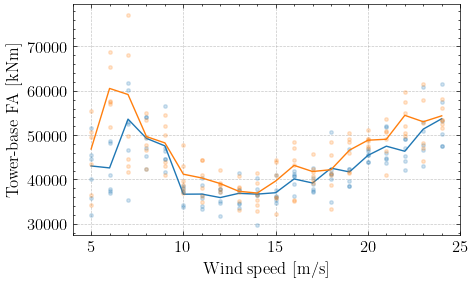

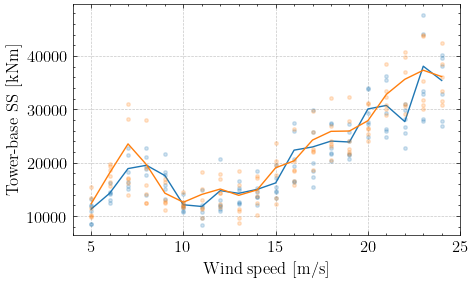

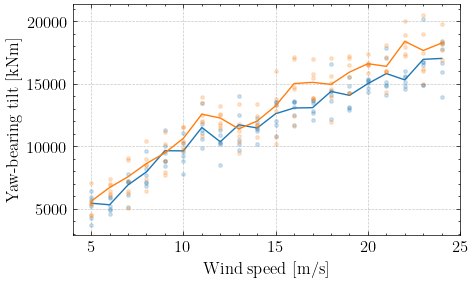

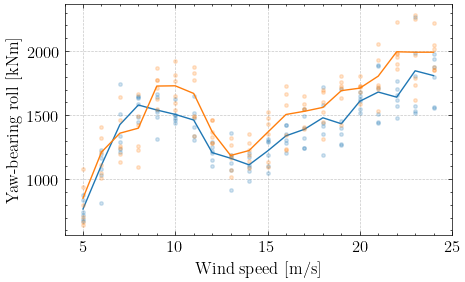

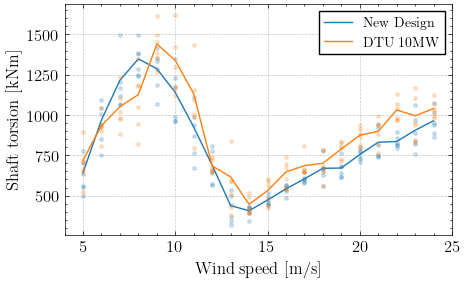

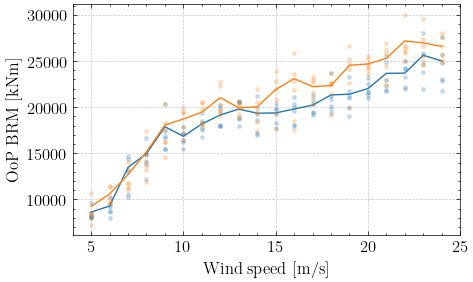

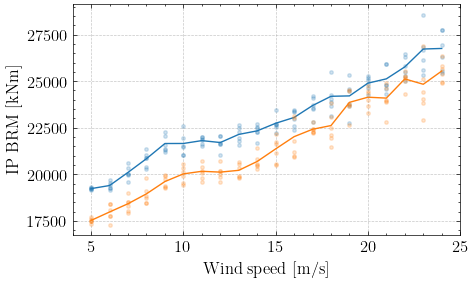

In [7]:
from helper_functions import propability_wsp, lifetime_eq_load


chan_ids_we_want = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

m_dict = {
    'TbFA': 4,
    'TbSS': 4,
    'YbTilt': 4,
    'YbRoll': 4,
    'ShftTrs': 4,
    'OoPBRM': 10,
    'IPBRM': 10
}

# Initialize dictfor Fatigue Loads
lifetime_eq_load_dict_BB = {key: None for key in chan_ids_we_want}
lifetime_eq_load_dict_DTU = {key: None for key in chan_ids_we_want}

# Wind speed propability for Fatigue Loads
P_wsp_DTU = propability_wsp(wsps_DTU, wind_class='I')
P_wsp_BB = propability_wsp(wsps_BB, wind_class='III')

# load the data from the stats file
df_BB, wsps_BB = load_stats(BB_PATH, subfolder=BB_SUBFOLDER, statstype='turb')
df_DTU, wsps_DTU = load_stats(DTU_PATH, subfolder=DTU_SUBFOLDER, statstype='turb')

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    if chan_id not in chan_ids_we_want: continue # Skip unwanted channels
    
    # isolate the channel data and get statistics
    chan_df_BB = df_BB.filter_channel(chan_id, CHAN_DESCS)
    chan_df_DTU = df_DTU.filter_channel(chan_id, CHAN_DESCS)

    # extract and order statistics
    points_BB, lines_BB = extract_and_combine_DEL(wsps_BB, chan_df_BB, SEEDS, m_dict[chan_id])
    points_DTU, lines_DTU = extract_and_combine_DEL(wsps_DTU, chan_df_DTU, SEEDS, m_dict[chan_id])

    # Calculate Fatigue Loads
    lifetime_eq_load_dict_BB[chan_id] = lifetime_eq_load(lines_BB['del'], P_wsp_BB, m=m_dict[chan_id])
    lifetime_eq_load_dict_DTU[chan_id] = lifetime_eq_load(lines_DTU['del'], P_wsp_DTU, m=m_dict[chan_id])

    # Initialize
    plt.figure(figsize=(5, 3))

    # Plot BB
    plt.plot(points_BB['wsp'], points_BB['del'], '.', color='tab:blue', alpha=0.2, markersize=5)
    plt.plot(lines_BB['wsp'], lines_BB['del'], '-', color='tab:blue', label='New Design')

    # Plot DTU
    plt.plot(points_DTU['wsp'], points_DTU['del'], '.', color='tab:orange', alpha=0.2, markersize=5)
    plt.plot(lines_DTU['wsp'], lines_DTU['del'], '-', color='tab:orange', label='DTU 10MW')


    # Add legend to only 1 from each group
    if chan_id == 'ShftTrs':
        plt.legend(loc='upper right', fontsize=10)

    # Formatting the plot
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel(chan_labels[iplot])
    plt.xlim([4, 25])
    plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='major')
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
    # plt.savefig(f'Plots/del_{chan_id}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

# Lifetime Fatigue Loads

In [8]:
chan_ids_we_want = ['TbFA', 'TbSS', 'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

print(f'Fatigue Loads for DTU')
print(f'Load channel \t Extreme value \t Design value')
for iplot, chan_id in enumerate(chan_ids):
    if chan_id not in chan_ids_we_want: continue # Skip unwanted channels

    fatigue_value_DTU = lifetime_eq_load_dict_DTU[chan_id]
    print(f'{chan_id} \t {fatigue_value_DTU:.2f}')


print(f'\nFatigue Loads for BB neo')
print(f'Load channel \t Lifetime Fatigue Load')
for iplot, chan_id in enumerate(chan_ids):
    if chan_id not in chan_ids_we_want: continue # Skip unwanted channels

    fatigue_value_BB = lifetime_eq_load_dict_BB[chan_id]
    print(f'{chan_id} \t {fatigue_value_BB:.2f}')

Fatigue Loads for DTU
Load channel 	 Extreme value 	 Design value
TbFA 	 129826.23
TbSS 	 55207.15
YbTilt 	 32488.02
YbRoll 	 4039.54
ShftTrs 	 2839.47
OoPBRM 	 31335.80
IPBRM 	 31017.46

Fatigue Loads for BB neo
Load channel 	 Lifetime Fatigue Load
TbFA 	 117165.77
TbSS 	 44261.97
YbTilt 	 25196.82
YbRoll 	 3584.39
ShftTrs 	 2833.79
OoPBRM 	 26016.96
IPBRM 	 31303.67
